# 2. Fasea: Algoritmoak diseinatzen

**Julen Etxaniz eta Aitor Zubillaga**

Community Detection proiektuaren 1. fasea entregatu duzue, eta feedback-a jaso ere. Klasean hainbat algoritmo ikusi ditugu, batzuk soluzio bakarrean oinarritutakoak, beste batzuk aldiz, populazio bat erabiltzen dutenak. Horiez gain, hibridatzeko teknikak ere ikusi ditugu. Bigarrengo fase honetan, bi algoritmo diseinatu beharko dituzue, bata soluzio bakarrean oinarritutakoa, eta bestea poblazionala. Ez hori bakarrik, bi algoritmoetako batek operadore probabilistikoak erabili beharko ditu, Estimation of Distribution Algorithms (EDAk) edo Ant Colony Optimization (ACO)-ek egiten duten bezala. Algoritmoen helburua, komunitate kopuru jakin bat emanik, modularity maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

Errepasatu gaitegian zehar ikusi ditugun algoritmo guztiak, eta horiek kontuak izanik, libre zarete nahi dituzuen diseinuak sortzeko, baita ere hibridoak! Adi! Egiten duzuen aukeraketa argudiatu egin beharko duzue.


#### Entregablea

Bigarrengo fasea ebaluatu ahal izateko, notebook honetan bertan algoritmoen diseinua eta implementazioa proposatu beharko duzue. Gogoratu algoritmo bat azaltzeko modurik errezena diagrama bat egitea dela. Adi! Atal bakoitzean hartutako erabakiak eta garatutako metodoak egoki argudiatu beharko dituzue. Ez argudiatzeak edo lana garaiz ez entregatzeak penalizazioa jasoko dute ebaluagarria den proiektuaren zati honetan. eGelan zehazten dira notebook-a igotzeko <b>egun eta orduak</b>.

Momentuz, ez daukazue algoritmoen exekuzio eta konparaketak egin behar. Hirugarren fasean, esperimentazioaren inguruko baldintzak emango dizkizuet, eta, horrez gain, txostenaren idazketa burutu beharko duzue.

## Aukeraketa

Algoritmo hauek diseinatu eta inplementatu ditugu:

1. ILS metodo eraikitzaile estokastiko batekin.

2. UMDA metodo eraikitzaile estokastiko batekin.

Bi algoritmo hauek eskatutako baldintzak betetzen dituzte. Lehenengoa soluzio bakarrean oinarritutakoa da eta bigarrena poblazionala. UMDAk operadore probabilistikoak erabiltzen ditu.

## Grafoa Sortu

Sarrerako kodea erabiliz grafoa sortu eta bistaratuko dugu, ondoren erabili ahal izateko. Grafo horretan, autore bakoitzeko nodo bat izango dugu, eta bi autoreren artean elkarlana egon bada (artikulu bat batera idatzi badute), orduan dagozkien nodoen artean arku bat egongo da. Baina ez da berdina elkarlan bat egitea, edo 100. Horregatik, arkuek pisu bat izango dute, elkarlan kopurua adieraziko duena.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection


In [3]:
%cd /content/drive/MyDrive/Proiektua - Community Detection

[Errno 2] No such file or directory: '/content/drive/MyDrive/Proiektua - Community Detection'
/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection


In [4]:
# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

def sortu_grafoa():
    # Get data
    connect = sqlite3.connect('data/database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)

    # Have a look at data
    df.head(10)

    # Initialize graph
    G = nx.Graph()

    # Transform
    # Autorearen IDa erabili beharrean erabili izena.
    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] +=1
            else:
                G.add_edge(u, v, weight=1)
                
    # Print graph size
    print('Autore kopurua grafoan:', G.number_of_nodes())
    print('Elkarlan kopurua grafoan:', G.number_of_edges())
    
    return G

def bistaratu_grafoa(G):
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)
    plt.show()

    plt.axis('off')
    plt.show()

In [5]:
G = sortu_grafoa()

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3215


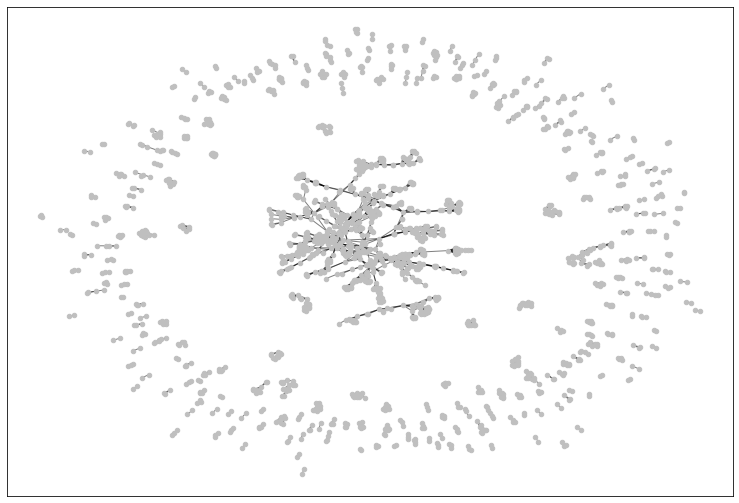

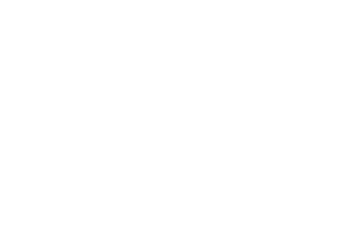

In [6]:
bistaratu_grafoa(G)

## Helburu-funtzioa

1.fasean definitu genuen helburu funtzioa erabiliko dugu, modularitatea. Modularitateak sare baten komunitate banaketaren egokitasuna neurtzen du. Banaketa egokia izango da komunitateen barruan ertz asko badaude, eta komunitate artean gutxi.

In [7]:
from collections import defaultdict
def modularity(G, partition, weight='weight'):
    weights = defaultdict(int)
    degrees = defaultdict(int)
    sum = G.size(weight=weight)
    modularity = 0

    for node in G:
        community = partition[node]
        degrees[community] += G.degree(node, weight=weight)
        for neighbour, data in G[node].items():
            if partition[neighbour] == community:
                if neighbour == node: # 4 nodes have self edges
                    weights[community] += data[weight] * 2
                else:
                    weights[community] += data[weight]

    for community in set(partition.values()):
        modularity += (weights[community] / (2 * sum)) - (degrees[community] / (2 * sum)) ** 2
    return modularity

## Random Search

Hasteko, ausazko bilaketa inplementatuko dugu baseline edo oinarri-lerro moduan erabiltzeko. Horrela, inplementatzen ditugun beste algoritmoak konparatu ditzakegu.

In [8]:
def random_search(G, max_evals, com_count):
    size = G.number_of_nodes()
    best_solution = list(np.random.randint(com_count, size=size))
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    for i in range(max_evals-1):
        solution = list(np.random.randint(com_count, size=size))
        partition = dict(zip(G.nodes, best_solution))
        fitness = modularity(G, best_partition)
        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = solution
    return (best_fitness, best_solution, max_evals)

## Metodo Eraikitzailea

Bi algoritmoen hasieraketarako metodo eraikitzaile estokastikoa erabili dugu. Jadanik existitzen diren metodoetako batzuk konparatu ditugu. Gure ustez egokiena dena aukeratu dugu eta aldaketa batzuk egin ditugu problema honetara egokitzeko.

### Aukeraketa

Metodoa aukeratzeko CDLib [1] liburutegiko [2] hainbat metodo probatu ditugu. Denbora, modularitatea eta komunitate kopurua kontuan hartu ditugu. Louvain aukeratu dugu modularitate onena lortzen duelako denbora gutxian eta sinplea delako. Leiden azkarragoa da, baina konplexuagoa da eta kodea C++ lengoaian [3] bakarrik aurkitu dugu. Beraz, Louvain moldatzea errazagoa izango da.

[1] Rossetti, G., Milli, L. & Cazabet, R. [CDLIB: a python library to extract, compare and evaluate communities from complex networks](https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0165-9
). Appl Netw Sci 4, 52 (2019).

[2] CDlib - Community Discovery Library https://cdlib.readthedocs.io/en/latest/

[3] Implementation of the Leiden algorithm for various quality functions to be used with igraph in Python https://github.com/vtraag/leidenalg

In [9]:
!pip install cdlib
!pip install python-igraph
!pip install leidenalg
from cdlib import algorithms
from timeit import default_timer

In [10]:
def test_algorithm(method, **kwargs):
    start = default_timer()
    com = method(G, **kwargs)
    end = default_timer()
    partition = {key: value[0] for key, value in com.to_node_community_map().items()}
    com_count = len(set(list(partition.values())))
    print("Denbora:", end - start)
    print("Modularitatea:", com.newman_girvan_modularity().score)
    print("Komunitateak:", com_count)

#### AGDL

[1] Zhang, W., Wang, X., Zhao, D., & Tang, X. (2012, October). [Graph degree linkage: Agglomerative clustering on a directed graph](https://link.springer.com/chapter/10.1007/978-3-642-33718-5_31). In European Conference on Computer Vision (pp. 428-441). Springer, Berlin, Heidelberg.

In [11]:
test_algorithm(algorithms.agdl, number_communities=291, kc=10)

Denbora: 4.787217234999844
Modularitatea: 0.9684210220918499
Komunitateak: 291


#### Louvain

[1] Blondel, Vincent D., et al. [Fast unfolding of communities in large networks](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008). Journal of statistical mechanics: theory and experiment 2008.10 (2008): P10008.


<figure>
    <img src='https://drive.google.com/uc?export=view&id=1Io2J3mHJ-mFTYVk0XDMkbeBsfpcrStOf' alt='Louvain' />
    <figcaption><b>1. Irudia.</b> Algoritmoaren pausuen ikustaratzea. Iterazio bakoitzak bi fase ditu: batean komunitateen aldaketa lokala bakarrik baimenduta modularitatea optimizatzen saiatzen da eta bestean, aurkitutako komunitateak agregatzen dira komunitateen sare berri bat sortzeko. Iterazio hauek modularitatea hobetzea posible ez den arte errepikatzen dira.</figcaption>
</figure>

In [12]:
test_algorithm(algorithms.louvain)

Denbora: 0.27439092500026163
Modularitatea: 0.9722637390442146
Komunitateak: 291


#### Leiden

[1] Traag, V.A., Waltman, L. & van Eck, N.J. [From Louvain to Leiden: guaranteeing well-connected communities](https://www.nature.com/articles/s41598-019-41695-z). Sci Rep 9, 5233 (2019).

<figure>
    <img src='https://drive.google.com/uc?export=view&id=1KotmWxIHsHW57-Nx6muiFtSYh4-wlUXR' alt='Leiden' />
    <figcaption><b>Figure 2.</b> Leiden algorithm. The Leiden algorithm starts from a singleton partition (a). The algorithm moves individual nodes from one community to another to find a partition (b), which is then refined (c). An aggregate network (d) is created based on the refined partition, using the non-refined partition to create an initial partition for the aggregate network. For example, the red community in (b) is refined into two subcommunities in (c), which after aggregation become two separate nodes in (d), both belonging to the same community. The algorithm then moves individual nodes in the aggregate network (e). In this case, refinement does not change the partition (f). These steps are repeated until no further improvements can be made.</figcaption>
</figure>

In [13]:
test_algorithm(algorithms.leiden)

Denbora: 0.05652737199852709
Modularitatea: 0.9703494703009221
Komunitateak: 291


### Inplementazioa

Metodo eraikitzaile estokastikoa inplementatzeko Louvain Heuristikoan oinarritu gara [1].  Community liburutegiko [2] inplementazioa hartu dugu GitHub-etik [3] eta hainbat funtzio moldatu ditugu gure beharretara.

[1] Blondel, Vincent D., et al. [Fast unfolding of communities in large networks. Journal of statistical mechanics](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008): theory and experiment 2008.10 (2008): P10008.

[2] Community detection for NetworkX’s documentation https://python-louvain.readthedocs.io/en/latest/

[3] Louvain Community Detection https://github.com/taynaud/python-louvain

#### Status

Community moduluak Status klaseako objektuak erabiltzen ditu kalkuluak egiterakoan egoera gerdetzeko. Honekin algoritmoa azkarragoa izatea lortzen da. Atal honetan aldaketa txikiak bakarrik egin ditugu. Adibidez, `dict([])` ordez `defaultdict(int)` erabili dugu adierazpen batzuk sinplifikatzeko.

In [14]:
class Status(object):
    """
    To handle several data in one struct.
    Could be replaced by named tuple, but don't want to depend on python 2.6
    """
    node2com = {}
    total_weight = 0
    internals = {}
    degrees = {}
    gdegrees = {}

    def __init__(self):
        self.node2com = defaultdict(int)
        self.total_weight = 0
        self.degrees = defaultdict(int)
        self.gdegrees = defaultdict(int)
        self.internals = defaultdict(int)
        self.loops = defaultdict(int)

    def __str__(self):
        return ("node2com : " + str(self.node2com) + " degrees : "
                + str(self.degrees) + " internals : " + str(self.internals)
                + " total_weight : " + str(self.total_weight))

    def copy(self):
        """Perform a deep copy of status"""
        new_status = Status()
        new_status.node2com = self.node2com.copy()
        new_status.internals = self.internals.copy()
        new_status.degrees = self.degrees.copy()
        new_status.gdegrees = self.gdegrees.copy()
        new_status.total_weight = self.total_weight

    def init(self, graph, weight, part=None):
        """Initialize the status of a graph with every node in one community"""
        count = 0
        self.node2com = defaultdict(int)
        self.total_weight = 0
        self.degrees = defaultdict(int)
        self.gdegrees = defaultdict(int)
        self.internals = defaultdict(int)
        self.total_weight = graph.size(weight=weight)
        if part is None:
            for node in graph.nodes():
                self.node2com[node] = count
                deg = float(graph.degree(node, weight=weight))
                if deg < 0:
                    error = "Bad node degree ({})".format(deg)
                    raise ValueError(error)
                self.degrees[count] = deg
                self.gdegrees[node] = deg
                edge_data = graph.get_edge_data(node, node, default={weight: 0})
                self.loops[node] = float(edge_data.get(weight, 1))
                self.internals[count] = self.loops[node]
                count += 1
        else:
            for node in graph.nodes():
                com = part[node]
                self.node2com[node] = com
                deg = float(graph.degree(node, weight=weight))
                self.degrees[com] += deg
                self.gdegrees[node] = deg
                inc = 0.
                for neighbor, datas in graph[node].items():
                    edge_weight = datas[weight]
                    if edge_weight <= 0:
                        error = "Bad graph type ({})".format(type(graph))
                        raise ValueError(error)
                    if part[neighbor] == com:
                        if neighbor == node:
                            inc += float(edge_weight) * 2
                        else:
                            inc += float(edge_weight)
                self.internals[com] += inc

#### Louvain

Community moduluak Louvain algoritmoa erabiltzen du partizio onena kalkulatzeko, hau da, modularitate maximoa duena.

In [15]:
import numbers
import networkx as nx
import numpy as np


def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance.
    Parameters
    ----------
    seed : None | int | instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError("%r cannot be used to seed a numpy.random.RandomState"
                     " instance" % seed)


def partition_at_level(dendrogram, level):
    """Return the partition of the nodes at the given level
    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1.
    The higher the level is, the bigger are the communities
    Parameters
    ----------
    dendrogram : list of dict
       a list of partitions, ie dictionnaries where keys of the i+1 are the
       values of the i.
    level : int
       the level which belongs to [0..len(dendrogram)-1]
    Returns
    -------
    partition : dictionnary
       A dictionary where keys are the nodes and the values are the set it
       belongs to
    """
    partition = dendrogram[0].copy()
    for index in range(1, level + 1):
        for node, community in partition.items():
            partition[node] = dendrogram[index][community]
    return partition


def best_partition(graph, com_count, level=3, min=0.0000001, partition=None, weight='weight', resolution=1., random_state=None):
    """Compute the partition of the graph nodes which maximises the modularity
    (or try..) using the Louvain heuristices
    This is the partition of highest modularity, i.e. the highest partition
    of the dendrogram generated by the Louvain algorithm.
    Parameters
    ----------
    graph : networkx.Graph
       the networkx graph which is decomposed
    com_count : int
       the number of communities
    level : int, optional
       the maximum level of the dendogram
    min : float, optional
       the minimum modularity improvement
    partition : dict, optional
       the algorithm will start using this partition of the nodes.
       It's a dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    Returns
    -------
    partition : dictionary
       The partition, with communities numbered from 0 to number of communities
    """
    dendo = generate_dendrogram(graph, com_count, level, min, partition, weight, resolution, random_state)
    return partition_at_level(dendo, len(dendo) - 1)


def best_fixed_partition(graph, com_count, level=3, min=0.0000001, partition=None, weight='weight', resolution=1., random_state=None):
    """Compute the partition of the graph nodes which maximises the modularity
    (or try..) using the Louvain heuristices
    This is the partition of highest modularity, i.e. the highest partition
    of the dendrogram generated by the Louvain algorithm.
    Parameters
    ----------
    graph : networkx.Graph
       the networkx graph which is decomposed
    com_count : int
       the number of communities
    level : int, optional
       the maximum level of the dendogram
    min : float, optional
       the minimum modularity improvement
    partition : dict, optional
       the algorithm will start using this partition of the nodes.
       It's a dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    Returns
    -------
    partition : dictionary
       The partition, with communities numbered from 0 to number of communities
    """
    original_partition = best_partition(graph, com_count, level, min, partition, weight, resolution, random_state)
    count = len(set(original_partition.values()))
    best_modul = 0
    if com_count < count:
        '''com_values = random.sample(range(count), com_count)'''
        com_values = list(range(com_count))
        for i in com_values:
            partition = original_partition.copy()
            for key, value in partition.items():
                if value not in com_values:
                    partition[key] = i
            modul = modularity(graph, partition)
            if modul > best_modul:
                best_modul = modul
                best_part = partition.copy()
    best_part = __renumber(best_part)
    return best_part


def generate_dendrogram(graph, com_count, level=3, min=0.0000001, part_init=None, weight='weight', resolution=1., random_state=None):
    """Find communities in the graph and return the associated dendrogram
    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1. The higher the level is, the bigger
    are the communities
    Parameters
    ----------
    graph : networkx.Graph
        the networkx graph which will be decomposed
    com_count : int
       the number of communities
    level : int, optional
       the maximum level of the dendogram
    min : float, optional
       the minimum modularity improvement
    part_init : dict, optional
        the algorithm will start using this partition of the nodes. It's a
        dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    Returns
    -------
    dendrogram : list of dictionaries
        a list of partitions, ie dictionnaries where keys of the i+1 are the
        values of the i. and where keys of the first are the nodes of graph
    """
    random_state = check_random_state(random_state)

    current_graph = graph.copy()
    status = Status()
    status.init(current_graph, weight, part_init)
    status_list = list()
    lvl = 0
    unique_values = set()
    while lvl <= level and len(unique_values) != com_count:
        __one_level(current_graph, com_count, min, status, weight, resolution, random_state)
        partition = __renumber(status.node2com)
        unique_values = set(partition.values())
        status_list.append(partition)
        current_graph = induced_graph(partition, current_graph, weight)
        status.init(current_graph, weight)
        lvl += 1
    return status_list[:]


def induced_graph(partition, graph, weight="weight"):
    """Produce the graph where nodes are the communities
    there is a link of weight w between communities if the sum of the weights
    of the links between their elements is w
    Parameters
    ----------
    partition : dict
       a dictionary where keys are graph nodes and  values the part the node
       belongs to
    graph : networkx.Graph
        the initial graph
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    Returns
    -------
    g : networkx.Graph
       a networkx graph where nodes are the parts
    """
    ret = nx.Graph()
    ret.add_nodes_from(partition.values())

    for node1, node2, datas in graph.edges(data=True):
        edge_weight = datas[weight]
        com1 = partition[node1]
        com2 = partition[node2]
        w_prec = ret.get_edge_data(com1, com2, {weight: 0}).get(weight, 1)
        ret.add_edge(com1, com2, **{weight: w_prec + edge_weight})

    return ret


def __renumber(dictionary):
    """Renumber the values of the dictionary from 0 to n
    """
    values = np.array(list(dictionary.values()))
    values += len(values) + 1
    search_list = []
    solution_list = np.zeros((len(values) + 1), dtype=int)
    n = 0
    for val in values:
        if val not in search_list:
            index_list = [i for i, e in enumerate(values) if e == val]
            for j in index_list:
                solution_list[j] = n
            search_list.append(val)
            n += 1
    ret = dict(zip(dictionary.keys(), solution_list))
    return ret


def __one_level(graph, com_count, min, status, weight_key, resolution, random_state):
    """Compute one level of communities
    """
    modified = True
    cur_mod = __modularity(status, resolution)
    new_mod = cur_mod
    while modified and len(status.node2com) != com_count:
        cur_mod = new_mod
        modified = False
        for node in __randomize(graph.nodes(), random_state):
            com_node = status.node2com[node]
            degc_totw = status.gdegrees.get(node, 0.) / (status.total_weight * 2.)
            neigh_communities = __neighcom(node, graph, status, weight_key)
            remove_cost = - resolution * neigh_communities.get(com_node,0) + \
                (status.degrees.get(com_node, 0.) - status.gdegrees.get(node, 0.)) * degc_totw
            __remove(node, com_node,
                     neigh_communities.get(com_node, 0.), status)
            best_com = com_node
            best_increase = float('-inf')
            for com, dnc in __randomize(neigh_communities.items(), random_state):
                incr = remove_cost + resolution * dnc - status.degrees[com] * degc_totw
                if incr > best_increase:
                    best_increase = incr
                    best_com = com
            __insert(node, best_com, neigh_communities[best_com], status)
            if best_com != com_node:
                modified = True
                if len(status.node2com) == com_count:
                    break
        new_mod = __modularity(status, resolution)
        if new_mod - cur_mod < min :
            break


def __neighcom(node, graph, status, weight_key):
    """
    Compute the communities in the neighborhood of node in the graph given
    with the decomposition node2com
    """
    weights = defaultdict(int)
    for neighbor, datas in graph[node].items():
        if neighbor != node:
            neighborcom = status.node2com[neighbor]
            weights[neighborcom] += datas[weight_key]
    return weights


def __remove(node, com, weight, status):
    """ Remove node from community com and modify status"""
    status.degrees[com] -= status.gdegrees[node]
    status.internals[com] -= weight + status.loops[node]
    status.node2com[node] = -1


def __insert(node, com, weight, status):
    """ Insert node into community and modify status"""
    status.node2com[node] = com
    status.degrees[com] += status.gdegrees[node]
    status.internals[com] += weight + status.loops[node]


def __modularity(status, resolution):
    """
    Fast compute the modularity of the partition of the graph using
    status precomputed
    """
    links = float(status.total_weight)
    result = 0.
    for community in set(status.node2com.values()):
        in_degree = status.internals[community]
        degree = status.degrees[community]
        if links > 0:
            result += in_degree * resolution / (2 * links) -  ((degree / (2. * links)) ** 2)
    return result


def __randomize(items, random_state):
    """Returns a List containing a random permutation of items"""
    randomized_items = list(items)
    random_state.shuffle(randomized_items)
    return randomized_items

### Konparazioa

Gure inplementazioa eta emaitzak community modulukoarekin konparatzen ditugu, egindako aldaketak hobeto ulertu ahal izateko.

#### Random State

Ausazko egoera hasieratzen dugu emaitzak erreproduzitu ahal izateko.

In [16]:
import random
import numpy as np
random.seed(0)
np.random.seed(0)
rs = np.random.RandomState(0)

#### Generate Dendogram

Community moduluko `generate_dendogram` funtzioak komunitateak elkartzen ditu bakarrik hobetzen bada. Beraz, komunitate kopuru optimora iritsitakoan gelditu egiten da. Guri interesatzen zaigu emandako komunitate kopurua izatea, ez optimoa. 

Beraz, helburuko komunitate kopurura iritsitakoan algoritmoa geratzen dugu. Gainera, aldaketa batzuk egin ditugu komunitate kopurua gehiago jaitsi ahal izateko modularitatea asko txartu gabe. Horrela, `292` komunitate ingurutik `279` komunitate ingurura jaistea lortzen dugu.

Hala ere, honek ez du balio emandako komunitate kopurua `279` baino txikiagoa bada. Izan ere, komunitateen artean ertzik ez dagoenean algoritmoa geratu egiten da. Hurrengo atalean komentatuko dugu nola lortu dugun txikitzea.

In [17]:
def print_levels(dendo):
    for level in range(len(dendo)):
        partition = partition_at_level(dendo, level)
        com_count = len(set(partition.values()))
        modul = modularity(G, partition)
        print("level", level, "com_count", com_count, "modularity", modul)

In [18]:
dendo = community.generate_dendrogram(G, random_state=rs)
print_levels(dendo)

level 0 com_count 503 modularity 0.8148171576276042
level 1 com_count 313 modularity 0.9599615201171859
level 2 com_count 291 modularity 0.9722637390442147


In [19]:
dendo = generate_dendrogram(G, 50, random_state=rs)
print_levels(dendo)

level 0 com_count 501 modularity 0.8173900564269182
level 1 com_count 310 modularity 0.9620794909841452
level 2 com_count 286 modularity 0.9692243480796483
level 3 com_count 279 modularity 0.9588916855535491


#### Best Partition

Community moduluko `best_partition` edo gurea erabiltzen badugu antzeko arazoa daukagu, komunitate kopurua ezin da nahi adina jaitsi. Hori konpontzeko, `best_fixed_partition` funtzioa inplementatu dugu. Honek lehenengo aurreko funtzioari deituko dio. Gero, soberan geratzen diren komunitate guztiak komunitate berean elkartuko ditu. Izan ere, komunitateen artean konexiorik ez dagoenean, modularitate hobea lortzen da soberan dauden guztiak elkarrekin jarrita. Komunitatea aukeratzeko aukera guztiak aztertu eta onena aukeratzen da.

Funtzio hauei 3 parametro gehitu dizkiegu: `com_count`, `level` eta `min`. Hauekin komunitate kopurua, dendogramaren maila maximoa eta modularitatearen hobekuntza minimoa kontrola daiteke. Ikus daiteke komunitate kopurua nahi adina gutxitu daitekeela, eta modularitatea ez dela horrenbeste jaisten.

In [20]:
def print_partition(partition):
    com_count = len(set(partition.values()))
    modul = modul = modularity(G, partition)
    print("com_count", com_count, "modularity", modul)

In [21]:
best_part_com = community.best_partition(G, random_state=rs)
print_partition(best_part_com)

com_count 292 modularity 0.9722795530305456


In [22]:
best_part = best_partition(G, 50, random_state=rs)
print_partition(best_part)

com_count 279 modularity 0.95437926466843


In [23]:
best_fixed_part = best_fixed_partition(G, 50, random_state=rs)
print_partition(best_fixed_part)

com_count 50 modularity 0.8019663527406498


In [24]:
best_fixed_part = best_fixed_partition(G, 50, random_state=rs)
print_partition(best_fixed_part)

com_count 50 modularity 0.797865340678215


#### Induced Graph

Aurreko partizioak grafo moduan bistaratu ditzakegu aldea hobeto ikusteko.

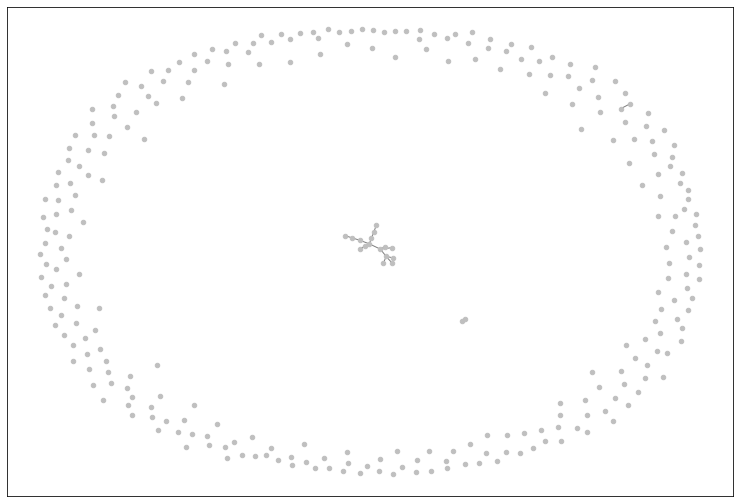

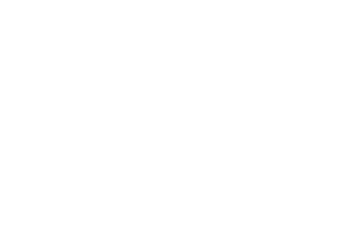

In [25]:
graph_com = community.induced_graph(best_part_com, G)
bistaratu_grafoa(graph_com)

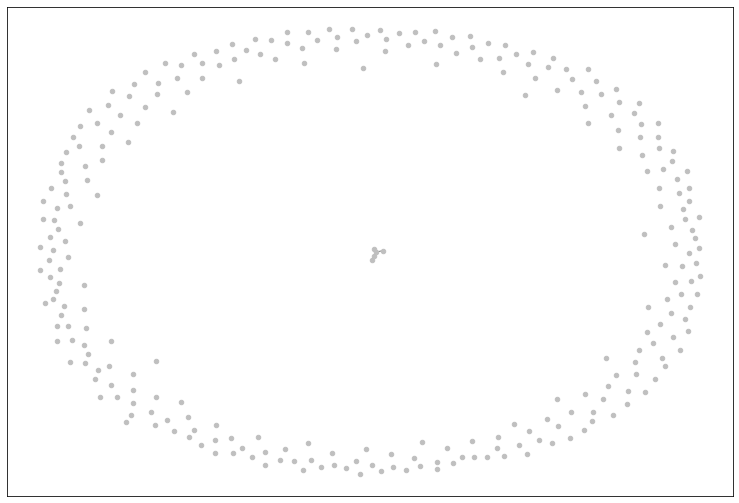

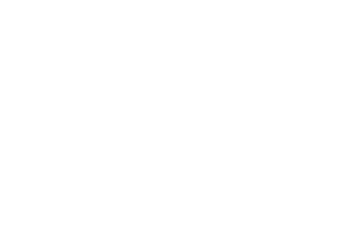

In [26]:
graph = induced_graph(best_part, G)
bistaratu_grafoa(graph)

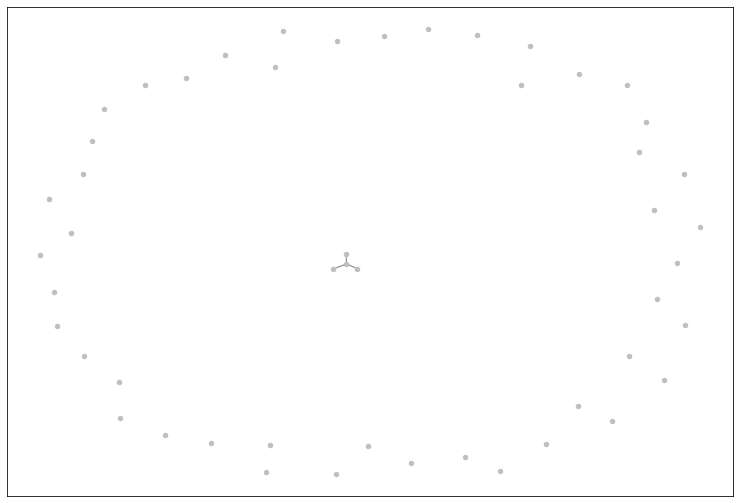

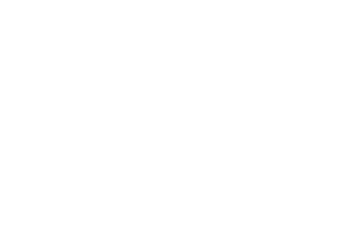

In [27]:
graph_fixed = induced_graph(best_fixed_part, G)
bistaratu_grafoa(graph_fixed)

## 1. ILS

community detection local search https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+local+search&oq=com

An evolutionary method for community detection using a novel local search strategy https://www.sciencedirect.com/science/article/pii/S0378437119301402

An iterated local search algorithm for community detection in complex networks https://www.worldscientific.com/doi/abs/10.1142/S0217979220500137

A novel iterated greedy algorithm for detecting communities in complex network https://link.springer.com/content/pdf/10.1007/s13278-020-00641-y.pdf

### Diseinua

![ILS](https://drive.google.com/uc?export=view&id=1ItmPvyTUC_ThfOqLzg4mj8MzFG7RsTXU)

### Local Search

#### Swap

In [28]:
def swap(solution, i, j):
    solution[i], solution[j] = solution[j], solution[i]
    return solution

def swap_neighbours(solution):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for j in range(i+1, size):
            neighbours.append(swap(solution[:], i, j))
    return neighbours

def best_first_swap(G, best_solution, best_fitness, evals, max_evals):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in range(i+1, size):
            solution = swap(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def local_search_swap(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count, random_state=rs)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_swap(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

In [29]:
def local_search_swap(G, best_solution, evals, max_evals, com_count):
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    improve = True
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_swap(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

#### Insert

In [30]:
def insert(solution, i, j):
    solution.insert(j, solution.pop(i))
    return solution

def insert_neighbours(solution):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for j in list(range(0, i-1)) + list(range(i+1, size)):
            neighbours.append(insert(solution[:], i, j))
    return neighbours

def best_first_insert(G, best_solution, best_fitness, evals, max_evals):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in list(range(0, i-1)) + list(range(i+1, size)):
            solution = insert(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
            print(evals)
    return (best_fitness, best_solution, evals, improve)

def local_search_insert(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count, random_state=rs)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_insert(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

In [31]:
def local_search_insert(G, best_solution, evals, max_evals, com_count):
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    improve = True
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_insert(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

### Perturbazioa

In [ ]:
def perturbate_solution(best_solution, com_count):
    ci = random.randrange(com_count)
    cj = random.randrange(com_count)
    ck = random.randrange(com_count)
    while best_solution.count(ck) < 2:
        ck = random.randrange(com_count)
    solution = merge(best_solution, ci, cj)
    solution = split(solution, ck)
    return solution

#### Merge

In [ ]:
def merge(solution, ci, cj):
    # solution[solution == cj] = ci
    size = len(solution)
    for i in range(size):
        if solution[i] == cj:
            solution[i] = ci
    return solution

def merge_neighbours(solution, com_count):
    neighbours = []
    for ci in range(com_count):
        for cj in range(ci + 1, com_count):
            neighbours.append(merge(solution[:], ci, cj))
    return neighbours

def greedy_merge(G, best_solution, best_fitness, evals, max_evals, com_count):
    best_fit = float('-inf')
    improve = False
    neighs = merge_neighbours(best_solution, com_count)
    for n in neighs:
        partition = dict(zip(G.nodes, n))
        fitness = modularity(G, partition)
        evals += 1
        if fitness > best_fit:
            print(n)
            best_solution = n
            best_fit = fitness
        if evals == max_evals:
            break
    if best_fit > best_fitness:
        improve = True
    best_fitness = best_fit
    return (best_fitness, best_solution, evals, improve)

def local_search_merge(G, max_evals, com_count):
    best_part = best_partition(G, com_count)
    best_solution = list(best_part.values())
    best_fitness = modularity(G, best_part)
    unique_values = set(best_solution)
    improve = True
    evals = 1
    while evals < max_evals and len(unique_values) > com_count:
        best_fitness, best_solution, evals, improve = greedy_merge(G, best_solution, best_fitness, evals, max_evals, com_count)
        unique_values = set(best_solution)
        print(len(unique_values), evals)
        
    return (best_fitness, best_solution, evals)

#### Split

In [ ]:
def split(solution, community):
    com_count = len(set(solution))
    indices = [index for index, element in enumerate(solution) if element == community]
    index = random.choice(indices)
    solution[index] = com_count
    indices.remove(index)
    index = random.choice(indices)
    indices.remove(index)
    for i in indices:
        random_bit = random.getrandbits(1)
        random_boolean = bool(random_bit)
        if random_boolean:
            solution[i] = com_count  
    return solution

### Simulated Annealing

In [ ]:
import random
import math

def initial_temperature(best_fitness):
    return 0.025 * best_fitness

def update_temperature(temp):
    return 0.9 * temp
    
def simmulated_annealing(best_solution, best_fitness, solution, fitness, temp):
    if fitness > best_fitness:
        best_solution = solution
        best_fitness = fitness
    else:
        p = random.uniform(0, 1)
        if p <= math.exp((fitness - best_fitness) / temp):
            best_solution = solution
            best_fitness = fitness
    temp = update_temperature(temp)
    return best_solution, best_fitness, temp

### Iterated Local Search

In [ ]:
def ILS(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count, random_state=rs)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    print(best_fitness)
    evals = 1
    while evals < max_evals:
        best_solution = perturbate_solution(best_solution, com_count)
        best_partition = dict(zip(G.nodes, best_solution))
        best_fitness = modularity(G, best_partition)
        print(best_fitness)
        fitness, solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        print(fitness)
        if fitness > best_fitness:
            best_solution = solution
            best_fitness = fitness
    return (best_fitness, best_solution, evals)

### Stochastic Local Search

In [ ]:
def SLS(G, max_evals, com_count):
    evals = 1
    while evals < max_evals:
        best_partition = best_fixed_partition(G, com_count, random_state=rs)
        best_solution = list(best_partition.values())
        best_fitness = modularity(G, best_partition)
        fitness, solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        if fitness > best_fitness:
            best_solution = solution
            best_fitness = fitness

    return (best_fitness, best_solution, evals)

### Variable Neighbourhood Search

In [ ]:
def VNS(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count, random_state=rs)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        print(evals)
        best_fitness, best_solution, evals, improve = best_first_insert(G, best_solution, best_fitness, evals, max_evals)
        print(evals)

    return (best_fitness, best_solution, evals)

### Exekutatu

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import time as tm

# Egin exekuzioak budget desberdinetarako: 10, 100, 1000, 10000...
def run_search(function, com_count, budget=5, repetitions=1):
    list_budget = []
    list_fit = []
    list_time = []
    for exp in range(1, budget):
        budget = 10 ** exp
        avg_fit = 0
        avg_time = 0
        for rep in tqdm(range(repetitions), position=0, leave=True):
            start = tm.time()
            (fitness, sol, evals) = function(G, budget, com_count)
            end = tm.time()
            avg_time += end - start
            avg_fit += fitness
        avg_fit = avg_fit / repetitions
        avg_time = avg_time / repetitions
        print()
        print("Budget:", budget, " Average fitness:", avg_fit, " Average time:", avg_time)
        list_budget.append(budget)
        list_fit.append(avg_fit)
        list_time.append(avg_time)
    return list_budget, list_fit, list_time

In [ ]:
list_budget, list_fit_rs, list_time_rs = run_search(random_search, 50)

In [ ]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(local_search_swap, 50)

In [ ]:
list_budget, list_fit_ls_ins, list_time_ls_ins = run_search(local_search_insert, 50)

In [ ]:
list_budget, list_fit_ils, list_time_ils = run_search(ILS, 50)

In [96]:
list_budget, list_fit_sls, list_time_sls = run_search(SLS, 50)

  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 10  Average fitness: 0.7979980228839416  Average time: 2.436241626739502


  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 100  Average fitness: 0.8019663527406498  Average time: 4.2851927280426025


  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 1000  Average fitness: 0.7975537193351687  Average time: 23.210510969161987


100%|██████████| 1/1 [03:29<00:00, 209.27s/it]


Budget: 10000  Average fitness: 0.797865340678215  Average time: 209.26925015449524


In [111]:
list_budget, list_fit_vns, list_time_vns = run_search(VNS, 50)

  0%|          | 0/1 [00:00<?, ?it/s]

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
28

KeyboardInterrupt: ignored

In [ ]:
# Datuak gordetzeko egitura
datuak = pd.DataFrame({"n": list_budget, "RS": list_fit_rs, "LS Swap": list_fit_ls_swap, "LS Insert": list_fit_ls_ins, 
                       "ILS": list_fit_ils, "SLS": list_fit_sls, "VNS": list_fit_vns})
print(datuak)
print()

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line', x='n', y='RS', ax=ax, title='Algoritmoen Firness-ak')
datuak.plot(kind='line', x='n', y='LS Swap', ax=ax)
datuak.plot(kind='line', x='n', y='LS Insert', ax=ax)
datuak.plot(kind='line', x='n', y='ILS', ax=ax)
datuak.plot(kind='line', x='n', y='SLS', ax=ax)
datuak.plot(kind='line', x='n', y='VNS', ax=ax)
plt.show()

## 2. EDA

community detection eda https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+eda&btnG=

An EDA-based Community Detection in Complex
Networks http://webpages.iust.ac.ir/mozayani/Papers-pdf/ieee79189c24-5f04-20150417114429.pdf

The Improved Estimation of Distribution Algorithms for Community Detection https://ieeexplore.ieee.org/abstract/document/8711535

Community detection in the textile-related trade network using a biased estimation of distribution algorithm https://link.springer.com/content/pdf/10.1007/s12652-017-0489-1.pdf

A Method Towards Community Detection Based on Estimation of Distribution Algorithm https://link.springer.com/chapter/10.1007/978-3-319-68542-7_57

GA-EDA: Hybrid Evolutionary Algorithm Using Genetic and Estimation of Distribution Algorithms https://link.springer.com/chapter/10.1007/978-3-540-24677-0_38

https://medium.datadriveninvestor.com/population-initialization-in-genetic-algorithms-ddb037da6773

### Diseinua

Soluzio bakarrean oinarritutako algoritmoak

![Soluzio bakarra](https://drive.google.com/uc?export=view&id=1IWn8nDVbNDPBfUS0sntjpXkStxPsBzmg)

Populazioaetan oinarritutako algoritmoak

![Populazioak](https://drive.google.com/uc?export=view&id=1IWATIX65r4PRCkl5rsyixGs01KBG3SBo)

Estimation of Distribution Algorithm (EDA)

![EDA](https://drive.google.com/uc?export=view&id=1ILC5n5IYesrtbMsts6IUsP8zOvd4nBnp)

Univariate Marginal Distribution Algorithm (UMDA)

![EDA](https://drive.google.com/uc?export=view&id=1ILZxrJgEhh4rp8Sp3gDRU_xNjlcgbcw4)

### Hasierako Populazioa

Hasierako populazioa eraiki behar dugu. Bi modu probatu ditugu, ausaz `random_population` eta moldatutako louvain heuristikoa erabiliz, `louvain_population`.

Ausaz hasieratuta, espero den bezela emaitzak txarrak dira. Hasierako soluzioak oso txarrak dira. Pixkanaka hobetzen joaten dira, baina oso txarrak izaten jarraitzen dute.

Louvain heuristikoa erabiltzen badugu, berriz, hasieratik dauzkagun soluzioak oso onak da. Hasierako iterazioaetan soluzioa okerragoak lortzen dira. Pixkanaka hobetzen joaten dira, eta iterazio asko egiten badira, hasierako soluzio onena lortzen da gehienez. Izan ere, oso zaila da soluzio oso onetik hasita hobetzea.

In [61]:
com_count = 50
individuals = 50
count = int(individuals / 5)
tournament_size = int(individuals / 10)
size = G.number_of_nodes()

In [62]:
def random_population(individuals, size, com_count):
    population = np.zeros((individuals, size), dtype=int)
    for i in range(individuals):
        solution = np.random.randint(com_count, size=size)
        population[i] = solution
    return population

population = random_population(individuals, size, com_count)
print(population)

[[24 34 36 ...  8 22 14]
 [ 7 19 46 ...  5 19 14]
 [46  2 27 ...  1 21  5]
 ...
 [36  3 43 ... 42 21 33]
 [36 35  5 ...  3 48  5]
 [49 27  5 ... 10 10  5]]


In [63]:
from tqdm import tqdm
def louvain_population(individuals, size, com_count):
    population = np.zeros((individuals, size), dtype=int)
    for i in tqdm(range(individuals), position=0, leave=True):
        partition = best_fixed_partition(G, com_count, random_state=rs)
        solution = np.fromiter(partition.values(), dtype=int)
        population[i] = solution
    return population

louvain_pop = louvain_population(individuals, size, com_count)
print()
print(louvain_pop)

100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


[[ 0  0  0 ... 19 31 31]
 [ 0  0  0 ...  3 27 27]
 [ 0  0  0 ... 18 29 29]
 ...
 [ 0  0  0 ... 17 15 15]
 [ 0  0  0 ... 18  8  8]
 [ 0  0  0 ... 17 28 28]]


### Soluzio Aukeraketa

Soluzioak aukeratu behar ditugu eredua ikasteko. Horretarako, bi metodo probatu ditugu, select best eta tournament selection.

`best_selection` algoritmoa erabiltzen badugu, beti `count` soluzio onenak aukeratuko dira.

`tournament_selection` algoritmoak, berriz, ausazkotasuna dauka. `tournament_size` tamainako `count` txapelketa egiten dira. Txapelketako partaideak ausaz aukeratzen dira populazio osoa kontuan hartuz.

In [64]:
def solution_modularity(solution):
    partition = dict(zip(G.nodes, solution))
    return modularity(G, partition)

def best_selection(population, evals, count):
    size = population.shape[1]
    sorted_pop = np.array(sorted(population, key=solution_modularity, reverse=True))
    evals += individuals
    best = sorted_pop[:count]
    return best, evals

def tournament_selection(population, evals, tournament_size, count):
    size = population.shape[1]
    winners = np.zeros((count, size), dtype=int)
    for i in range(count):
        solutions = random.choices(population, k=tournament_size)
        solutions = np.array(sorted(solutions, key=solution_modularity, reverse=True))
        evals += tournament_size
        winners[i] = solutions[0]
    sorted_winners = np.array(sorted(winners, key=solution_modularity, reverse=True))
    return sorted_winners, evals

"""
def roulette_selection(population, evals, count):

def ranking_selection(population, evals, count):

def elitism_selection(population, evals, count):
"""

selected, evals = best_selection(louvain_pop, 0, count)
print(selected)
selected, evals = tournament_selection(louvain_pop, 0, tournament_size, count)
print(selected)

[[ 0  0  0 ... 18 29 29]
 [ 0  0  0 ... 18 29 29]
 [ 0  0  0 ... 18 29 29]
 ...
 [ 0  0  0 ... 18 29 29]
 [ 0  0  0 ... 17 29 29]
 [ 0  0  0 ... 17 29 29]]
[[ 0  0  0 ... 18 29 29]
 [ 0  0  0 ... 18 29 29]
 [ 0  0  0 ... 18 29 29]
 ...
 [ 0  0  0 ... 17 15 15]
 [ 0  0  0 ...  3 28 28]
 [ 0  0  0 ...  3 16 16]]


### Eredua Ikasi

Eredua ikasteak esan nahi du aukeratutako soluzioetatik probabilitate distribuzioa kalkulatzea.

Horretarako, populazioko soluzioen posizioa bakoitzean komunitate bakoitzaren probabilitatea kalkulatzen da, `get_distribution` funtzioan ikus daitekeen bezala.

Eredua lagintzeko probabilitate metatuak interesatzen zaizkigunez, aldaketa hori egiten dugu `cummulative_distribution` funtzioan.

In [65]:
def get_distribution(population, com_count):
    individuals = population.shape[0]
    size = population.shape[1]
    distribution = np.zeros((com_count, size), dtype=float)
    individuals = len(population)
    for individual in population:
        for i, com in enumerate(individual):
            distribution[com, i] += 1 / individuals
    return distribution

distribution = get_distribution(population, com_count)
print(distribution)

[[0.02 0.02 0.02 ... 0.   0.02 0.04]
 [0.   0.   0.06 ... 0.04 0.   0.02]
 [0.02 0.06 0.   ... 0.02 0.   0.02]
 ...
 [0.   0.02 0.04 ... 0.04 0.02 0.  ]
 [0.04 0.   0.04 ... 0.04 0.04 0.  ]
 [0.06 0.   0.   ... 0.02 0.04 0.02]]


In [66]:
def cummulative_distribution(population, com_count):
    individuals = population.shape[0]
    size = population.shape[1]
    distribution = np.zeros((com_count, size), dtype=float)
    for individual in population:
        for i, com in enumerate(individual):
            for j in range(com, com_count):
                distribution[j, i] += 1 / individuals
    return distribution
    
cum_distribution = cummulative_distribution(population, com_count)
print(cum_distribution)

[[0.02 0.02 0.02 ... 0.   0.02 0.04]
 [0.02 0.02 0.08 ... 0.04 0.02 0.06]
 [0.04 0.08 0.08 ... 0.06 0.02 0.08]
 ...
 [0.9  1.   0.96 ... 0.94 0.92 0.98]
 [0.94 1.   1.   ... 0.98 0.96 0.98]
 [1.   1.   1.   ... 1.   1.   1.  ]]


### Eredua Lagindu

Eredua lagintzeko ausazko zenbakiak kalkulatzen dira, eta probabilitate distribuzio metatua erabiliz, dagokion komunitatea aukeratzen da.

`generate_solution` metodoan aurreko pausoak jarraituz soluzio bat eraikitzen da.

`generate_population` metodoan aurreko algoritmoa hainbat aldiz errepikatzen da `individuals` soluzio eraiki arte.

In [67]:
def generate_solution(distribution, individuals):
    com_count = distribution.shape[0]
    size = distribution.shape[1]
    solution = np.zeros(size, dtype=int)
    for i in range(size):
        r = random.uniform(0, 1)
        for j in range(com_count-1):
            if j == 0 and distribution[j][i] > r:
                solution[i] = j
                break
            elif distribution[j][i] <= r and distribution[j+1][i] > r:
                solution[i] = j+1
                break
    return solution

generated_solution = generate_solution(cum_distribution, individuals)
print(generated_solution)
print(solution_modularity(generated_solution))

[40 13  1 ... 26 48 24]
0.005534609174694614


In [68]:
def generate_population(distribution, individuals):
    com_count = distribution.shape[0]
    size = distribution.shape[1]
    population = np.zeros((individuals, size), dtype=int)
    for i in range(size):
        randoms = np.random.uniform(size=individuals)
        for k, r in enumerate(randoms):
            for j in range(com_count-1):
                if j == 0 and distribution[j][i] > r:
                    population[k][i] = j
                    break
                elif distribution[j][i] <= r and distribution[j+1][i] > r:
                    population[k][i] = j+1
                    break
    return population

generated_population = generate_population(cum_distribution, individuals)
print(generated_population)
print(solution_modularity(generated_population[0]))

[[30  0  5 ...  1 21 37]
 [35 41 38 ...  3 31 18]
 [15 28  3 ... 41  9  3]
 ...
 [48  3  9 ... 32 38 37]
 [35 26 43 ... 45 19 17]
 [36 19 32 ... 33 33 19]]
-0.0021585069766240678


### UMDA

EDA exekutatzeko aurretik definitutako metodoak erabiltzen dira hainbat iteraziotan.

Hasteko, parametroak aukeratu behar ditugu:
* `com_count`: komunitate kopurua
* `individuals`: indibiduo kopurua
* `count`: aukeratutako soluzio kopurua
* `tournament_size`: txapelketa bakoitzaren tamaina

Ondoren, hasierako populazioa eraikitzen dugu. Horrekin hainbat iterazio egingo ditugu ebaluazio kopuru maximora iritsi arte.

Gero, aukeraketa egiten dugu `best_selection` edo `tournament_selection` erabiliz. Distribuzioa metatua kalkulatu ondoren populazio berria eraikitzen dugu. Aurreko populazioko soluzio onena gordetzen dugu eta hurrengo iteraziora pasatzen gara.



In [69]:
com_count = 50
individuals = 50
count = int(individuals / 5)
tournament_size = int(individuals / 10)
def UMDA(G, max_evals, com_count, individuals, count, tournament_size):
    size = G.number_of_nodes()
    population = louvain_population(individuals, size, com_count)
    #population = random_population(individuals, size, com_count)
    print_modularity(population)
    evals = 0
    prev_evals = 0
    pbar = tqdm(total=max_evals, position=0, leave=True)
    while evals < max_evals:
        selected, evals = best_selection(population, evals, count)
        best = selected[0]
        selected, evals = tournament_selection(population, evals, tournament_size, count)
        distribution = cummulative_distribution(selected, com_count)
        new_population = generate_population(distribution, individuals-1)
        population = np.concatenate(([best], new_population))
        print_modularity(population)
        pbar.update(evals - prev_evals)
        prev_evals = evals
    pbar.close()

    sorted_population = np.array(sorted(population, key=solution_modularity, reverse=True))
    best_solution = sorted_population[0]
    best_fitness = solution_modularity(best_solution)
    return best_fitness, best_solution, evals, sorted_population

In [70]:
def print_modularity(population):
    print()
    sorted_population = np.array(sorted(population, key=solution_modularity, reverse=True))
    for sol in sorted_population:
        print(solution_modularity(sol))
    print()

In [71]:
best_fitness, best_solution, evals, sorted_population = UMDA(G, 5000, com_count, individuals, count, tournament_size)
print(best_fitness)
print(best_solution[:30])
print(sorted_population)

100%|██████████| 50/50 [01:47<00:00,  2.15s/it]



0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8033842584556201
0.8027667774544698
0.8023006939193549
0.8021202428505255
0.8021202428505255
0.8021202428505255
0.8018829104665217
0.8014877651233199
0.8008654214235302
0.799733965435121
0.7991003844065433
0.7989865809131806
0.7987743384196344
0.7987370713510719
0.7985415826931734
0.7981601264595861
0.7979106168974774
0.7979106168974774
0.7978828300481107
0.797865340678215
0.797865340678215
0.797865340678215
0.797865340678215
0.797865340678215
0.797865340678215
0.797865340678215
0.7978566777192948
0.7974450237185279
0.7971245759645063
0.7964361976344566
0.7963814411959984
0.7953118109474303
0.79426510484959
0.7936403502319876
0.7929457607238444


  0%|          | 0/5000 [00:00<?, ?it/s]

0.7928820961483832
0.7928820961483832
0.7928820961483832
0.7928820961483832
0.7913141005838182
0.7912980005563909
0.7885847373047608
0.7858356780530639
0.7858356780530639


0.8035493858942839
0.6215215768154374
0.6187345149609302
0.6185659141660953
0.6102315756026232
0.6078220879953946
0.6073036589396343
0.6031086210825036
0.6028439922052984
0.6012534402571295
0.6006570445710874
0.5998392530764132
0.5995962815965082
0.5967478843583247
0.5957292920139613
0.5953334519995253
0.5948244622999468
0.5937200576266566
0.5927858474057379
0.5924022662954342
0.5917635773901349
0.5912855618549981
0.5909111749227934
0.5907371802101403
0.5904421083876732
0.5902392235242812
0.5899821543046241
0.5898529454550686
0.5892715464950812
0.5887077594940308
0.5880095740406754
0.587475330998584
0.586377546133525
0.5855358906388066
0.585196931939545
0.5826004551812829
0.580317316012646
0.5802211653412337
0.5799437872037309
0.5795023440659219
0.5790875436130946
0.5785749171052901


  2%|▏         | 100/5000 [00:06<05:22, 15.20it/s]

0.5785414502970087
0.578037200707028
0.5769596838968015
0.574551626495055
0.5717644420515067
0.5717148752157977
0.5697603564039371
0.5681778953324957


0.8035493858942839
0.6353763859508385
0.6325995807127881
0.6240250084913342
0.6230895723800024
0.6220044959122275
0.6206766522796169
0.6201981463883142
0.619473767743129
0.619313421277077
0.6189174995366136
0.6185022087276206
0.6183494627821304
0.6173055353692268
0.6172689221088845
0.6165509998198757
0.6135545967458006
0.6131471516354524
0.6124327844286419
0.6118375737699989
0.6117769330575571
0.6116401236874394
0.6108374923708753
0.6106287232335
0.6103058236986519
0.6091944314500061
0.6081786995166067
0.6077899696665677
0.6076663999129129
0.6071724478024032
0.6068473416648115
0.6064498671298243
0.6061624366909326
0.6058267878957866
0.6055673077583171
0.6051299509218859
0.604937813031117
0.6047993691404483
0.6036371841656801
0.6032824523431016


  4%|▍         | 200/5000 [00:13<05:16, 15.18it/s]

0.602363647478376
0.6023008001631907
0.6018656907925172
0.6008661814755863
0.6006964773793797
0.6001317096659984
0.5966904309609574
0.5955544391780192
0.5945732364912597
0.593961680627107


0.8035493858942839
0.6941754432247653
0.6929901297842007
0.6902621967106255
0.6895753303120854
0.6881255923093849
0.6858164234009733
0.684974114098034
0.6835620517940334
0.6835501606570249
0.683118524642522
0.6794832283480784
0.6791904039913683
0.678886791799022
0.6777598716051417
0.6776412054131399
0.6774231195086237
0.6764066111779631
0.6753953333130653
0.6753718370801447
0.6743231695576434
0.6741070042147748
0.6739632889953292
0.6723693454170171
0.6721871372385952
0.6720228270602068
0.6712058528258079
0.6700814252757682
0.6700135518098882
0.6698292187547504
0.6697700491108044
0.6695352502336548
0.6694609204115983
0.6685652031496556
0.66833293777936
0.6678238254907403
0.66695887807817
0.6658413972404716
0.6654889128836508
0.6649947564580723


  6%|▌         | 300/5000 [00:19<05:10, 15.13it/s]

0.6648013518138763
0.6642937923197803
0.6608994652175662
0.6605006013401107
0.6597810853935648
0.659628094269992
0.659540851735583
0.6583058897332822
0.6576479952115084
0.6498072409914217


0.8035493858942839
0.7039881239005807
0.7036850429274132
0.7001656750030487
0.6996060968924167
0.6995122754127898
0.6986121858083733
0.6985925715617616
0.6981708652596059
0.6981331486978919
0.6966009899964071
0.6965702201470348
0.6963656599000784
0.695982405693885
0.6952772326651739
0.6948339915547592
0.6940681778136065
0.6939145737448272
0.6922013510293067
0.6916317614803004
0.6915930642062558
0.6905792119714901
0.690148556669318
0.6890966201057143
0.6887964404065245
0.6880831356380729
0.688037900281824
0.6879753390077346
0.6878660713089011
0.6877416025689432
0.6874247098971199
0.6871350728554846
0.6868621487864829
0.685714061551467
0.6854266311125757
0.6844667180559928
0.6842040506034484
0.6838934916987605
0.6833335866840188
0.681980694023964
0.6815102790093893


  8%|▊         | 400/5000 [00:26<05:03, 15.14it/s]

0.6809764854604494
0.6809273272548784
0.6802770741166807
0.6793651342382693
0.6792156164708675
0.6768340791650609
0.6760547806293622
0.6748060069284059
0.6711667060586121


0.8035493858942839
0.7198074224232027
0.7196255820119052
0.7167355862256993
0.7144021855501195
0.7140379326453309
0.7138974047409595
0.7124766794780385
0.7122288861625085
0.7114570246953171
0.7112725690511379
0.7112498492154793
0.7110253478178006
0.7108656142969549
0.7107926329543536
0.710535400282641
0.7103793444330355
0.7103705997480876
0.7101440551997203
0.7097603923633892
0.7088595263617109
0.7088086927725752
0.7085358504296011
0.7077914897706802
0.707492331646835
0.7069860389061656
0.7068543782757836
0.7067783730701626
0.7065895450835091
0.7057999082053258
0.705187044724732
0.7051851241630843
0.704859609395355
0.7047128703128896
0.7045406327098291
0.7038934034346508
0.7035890557080563
0.7029137535424148
0.7018106564855652
0.701214955470757
0.7011374383336259
0.6997570040022869


 10%|█         | 500/5000 [00:33<04:59, 15.05it/s]

0.6993568325083908
0.6983860907531578
0.6981385017526965
0.6979251559577784
0.6978328464096611
0.6957377996934295
0.6944602992937888
0.69184988824783


0.8035493858942839
0.7460349391843939
0.7457802808825497
0.7453819482242733
0.7440273393176398
0.7431823739188055
0.7421104144784524
0.7412279776959866
0.7405657516947528
0.7391333804729059
0.7389780192945343
0.7381162183340247
0.737908266456925
0.7377287961004263
0.7376531177989153
0.7369246528523526
0.7349155001910754
0.7344624928203685
0.734404712518891
0.7342526203816212
0.7341663585595426
0.7340869617237783
0.7339126809700292
0.7334061839142912
0.7334048354348364
0.7333203307223504
0.7329668656531986
0.7321013461584354
0.7320673481309748
0.7318753328292471
0.7312380741294299
0.7307431821696035
0.7304601649361997
0.7301227590314616
0.7298062749897761
0.72939809434518
0.729106168974773
0.7285143908092871
0.7274941230813589
0.7274099861359967


 12%|█▏        | 600/5000 [00:39<04:53, 15.02it/s]

0.7266879775456104
0.726368633092961
0.7259949816950044
0.7252350930908489
0.7245042580894874
0.7228608702645078
0.7204074140544577
0.7202949181775358
0.7161832817315195
0.7136532482336553


0.8035493858942839
0.7587880406054134
0.7564157383407197
0.7551050571738943
0.7549369467352252
0.7545510364331361
0.7543250231039478
0.7527230295119224
0.7516147019893098
0.7515814394960969
0.7509813252758011
0.7505682819325658
0.7504787510693849
0.7497485290132301
0.7496565463692231
0.7492326743273375
0.7484423427779199
0.7483294382708603
0.7479591785030474
0.7477771337766805
0.7477086473655943
0.7476230802147499
0.747552264611878
0.7471654961865002
0.7471499273782519
0.7465304032264128
0.7464105928700251
0.7463659704589831
0.746293602061588
0.7459267339239184
0.7459122684170421
0.7458818663347936
0.7451284340868144
0.7446352992365808
0.7444293087841423
0.7443101522359752
0.7441784098795653
0.7427318591919385
0.7422810992869894
0.7422471421225426
0.7414967746005966
0.740973891476335
0.740947575695

 14%|█▍        | 700/5000 [00:46<04:47, 14.97it/s]

0.7337040344216951


0.8035493858942839
0.7630858898052011
0.7630044089557342
0.762799276626585
0.760717142622706
0.7601067717859523
0.7578940804530631
0.7576297784799677
0.7566337016561944
0.7563695631351545
0.7562247854773502
0.7561464510799438
0.7554957893116087
0.7550642350231334
0.7546270825017709
0.7542374536654287
0.7541091846651897
0.7539566838977823
0.7538050821166782
0.7528427990052962
0.752563622895187
0.7522801153056177
0.7517930281814225
0.7516395467016848
0.7513618416600714
0.7511398737692472
0.7511361960980072
0.750845455755
0.750797155672718
0.7506441645491453
0.7504617520556548
0.7504355180008114
0.7501241418358477
0.7500447041370695
0.7500234962329205
0.7497711262598477
0.7497208238898907
0.7490629293681172
0.7488899153677948
0.7487651605867405
0.7485263571342409


 16%|█▌        | 800/5000 [00:53<04:41, 14.93it/s]

0.7480942716265866
0.7476496820367172
0.7471095138576287
0.7463631509110326
0.7453419024707738
0.7447721903327263
0.7447279765518221
0.7446732609763773
0.7441301097972836


0.8035493858942839
0.7706076264767484
0.7684532466645156
0.7679286064306614
0.7667470523873644
0.7656086088235996
0.7655501747139019
0.7654863058233715
0.7648614286167282
0.7640110284370616
0.7638796538477758
0.7638482301901829
0.7637971105599509
0.7637674848749642
0.7632824000384438
0.7628652295308174
0.7625756742152096
0.7625574493110661
0.762545067817892
0.762418474201218
0.7618407529124706
0.7609579892258944
0.7609389879244891
0.7608253070201679
0.7606730922938567
0.7606068124855141
0.7604425840331531
0.760114985251721
0.7600463353885795
0.7598133344840359
0.7597867326620684
0.7596766885659729
0.7593354006749262
0.7592667099487709
0.7588723410028306
0.7584490001801242
0.7581764030152325
0.7580714667958591
0.7577447261377162
0.757492560479712
0.7568488045607045


 18%|█▊        | 900/5000 [01:00<04:35, 14.89it/s]

0.7566994911083716
0.7558496221478841
0.7555344457226395
0.7554377638320484
0.7553143983934625
0.7552620528728171
0.7545254561865131
0.752278113017943
0.7517824037978412


0.8035493858942839
0.7831555547056049
0.7810785285784477
0.7810095109481822
0.7802082281110728
0.7798396028638107
0.7790417116568448
0.7788544364647152
0.7788525159030676
0.7788157800536843
0.7784288073132374
0.7783446703678751
0.7783242797240014
0.7783122251349378
0.7777094139557328
0.7776208638048828
0.7770417531736669
0.7769835642420515
0.7769697116803818
0.7768962808446288
0.776732052392268
0.7764032277204226
0.7763767484874964
0.7761483651035093
0.7758696793495653
0.7758498199248709
0.7757080252670725
0.7756913940204662
0.7755124548831466
0.775389375485657
0.7753768305404282
0.7751073798275974
0.7747711589502586
0.7746497549363338
0.7744714287442209
0.7740171954831006
0.77316025722123
0.7729955792757178
0.7725657412338209
0.772533990672118


 20%|██        | 1000/5000 [01:06<04:28, 14.93it/s]

0.7725046101652141
0.7723917056581544
0.7721617694796439
0.7717249029993779
0.7709286871759766
0.7707776574770653
0.7706426052165397
0.7692115007481202
0.7690757946793741
0.7679680801019679


0.8035493858942839
0.7890545393741291
0.7875860452481056
0.7875285918507382
0.7872617972338029
0.7868362498083525
0.7867732390411118
0.7857403446419273
0.7854567144633167
0.785004728667954
0.784771441722314
0.7844573277354274
0.784366162351696
0.7842989835570503
0.7842766723515292
0.7836494250900867
0.7835987549530059
0.7835651655556831
0.7835124522679137
0.783260204883882
0.7832173804454462
0.7830379100889473
0.7829985181436686
0.78285022626668
0.7828018035953569
0.7827110059787493
0.7825236490605921
0.7823476111972504
0.7823108753478669
0.7820635315254884
0.7819048604430009
0.7815860880725441
0.7814541005380515
0.7813192525925949
0.7812443098253319
0.7812375265650453
0.781227801167767
0.7812204458252875
0.7810244668112237
0.780863507399965
0.7806947022900613


 22%|██▏       | 1100/5000 [01:13<04:21, 14.90it/s]

0.7801526952753529
0.7797913436445428
0.7796996879046459
0.779680114521048
0.7793090374929593
0.7792402241777627
0.7788988954237022
0.7786927006561946
0.7781383530113263


0.8035493858942839
0.7922723382568362
0.7913617059948658
0.7912330692275027
0.7911949440356507
0.7903315902806178
0.7902719302805065
0.7901669531981192
0.7899936531567004
0.7897564842247519
0.7897311082931977
0.7896652371149928
0.7895722737586552
0.7893875729363934
0.7892079799908533
0.7891706311962631
0.7886341406884144
0.7881272350025386
0.7881105220299046
0.787963660358398
0.7879625570570261
0.7875747261932899
0.7875533548370858
0.787522298946617
0.7874821306040763
0.7874330541245328
0.7873155729599305
0.7873010257270266
0.7871759031788482
0.7871608655897793
0.7870175998634849
0.7866622959587134
0.7866524479723936
0.7862951009169333
0.7862168891085686
0.7860795893822853
0.7851271133942095
0.7847237954482527
0.784690900722164
0.7843774405434977
0.7839690964468465
0.7837485178984904
0.7834803339390867
0.783087558650

 24%|██▍       | 1200/5000 [01:20<04:15, 14.87it/s]

0.7821830558407795
0.7819692196896961
0.7817817810455113


0.8035493858942839
0.7966727127581849
0.7949102092480518
0.7944664777814718
0.7943016772469182
0.7940898842465237
0.7940390506573878
0.7940039901915692
0.7939002798626088
0.793696496012914
0.793619224053866
0.7935211119577928
0.7933770289712231
0.7928909225593586
0.7928902278881242
0.7928618689565646
0.7927208915590417
0.7927040151343527
0.7926271518054424
0.7925426062299424
0.792270908051354
0.792210144749871
0.7921908165443556
0.792156287297716
0.7921356923387733
0.7920106515166228
0.7916242917213822
0.791358028323626
0.7911260489944267
0.7911151385697488
0.7911109705423438
0.7910535171449763
0.7909738751311296
0.7908522668021357
0.7907312714183486
0.7903246844312899
0.7900520464033847
0.7899887495950476
0.7897535829507739
0.7895127772105992
0.789480699744786
0.7890723556481347
0.788919936606755
0.7885193973457347
0.7882447978931685
0.7881780277286605
0.788116242851833
0.78713965768563


 26%|██▌       | 1300/5000 [01:27<04:10, 14.79it/s]

0.7867426326437945
0.7864390613144617


0.8035493858942839
0.7999158875724461
0.7990027218036216
0.7983108292543875
0.7978670977878073
0.7971810077865291
0.7971727125947327
0.7968812775804913
0.796866239991422
0.7965502871689156
0.7965377013606729
0.7963358789356395
0.7962420574560126
0.7962271424559849
0.7961772895791797
0.7961464380037797
0.7961001810721867
0.7960181690035407
0.7959873174281409
0.7959232442225419
0.7958419676881442
0.7957776084414488
0.7955501240437647
0.7954992495916151
0.7954308449065562
0.7954010557695144
0.7953658727146543
0.7953472391803729
0.795291542892598
0.7951040633853994
0.7950525759880432
0.7950438721661093
0.7948184309191139
0.7947740128231408
0.7947042596586272
0.7946593103434749
0.7942066707398919
0.7941260071507006
0.7940495524519281
0.7940486126026112
0.7939916495614091
0.7939486208079044
0.7938857326297051
0.7935144921495614
0.7935047258892691
0.7933459730807543
0.7932749122998
0.79318820098457


 28%|██▊       | 1400/5000 [01:33<04:03, 14.78it/s]

0.7930678594090034
0.791954914365834


0.8035493858942839
0.8014531541506524
0.8005532279982911
0.8004353790665647
0.7999692546684358
0.7998957012436414
0.799817938928428
0.7996716493391144
0.7994583035441963
0.7994036696947795
0.7993311378453293
0.7992664108315101
0.7991660512696793
0.7991573474477454
0.7991224504339816
0.7990987090229784
0.7990905364202234
0.7988087450772328
0.7985703911178846
0.7985383136520715
0.7984195248710282
0.7984178086244497
0.7984167461860916
0.79819968185692
0.7981897930075865
0.7979062445550034
0.7978916973220997
0.797865871897394
0.7978430294726939
0.7978351020480215
0.7977614260341858
0.7973664850060528
0.7973045366771702
0.7972361319921112
0.7971173432110681
0.797102264758985
0.7970332062657058
0.7970260143752814
0.796924306333996
0.7969113118956158
0.7968451138133006


 30%|███       | 1500/5000 [01:40<03:55, 14.88it/s]

0.7968193292516087
0.7967924005255312
0.7967661664706878
0.7965443620319184
0.7959315394143383
0.7958026983319065
0.7956290713863775
0.7953867945777071
0.7952217488650708


0.8035493858942839
0.8024614898785585
0.8017636313293132
0.8017557856306684
0.8017052380826291
0.8017052380826291
0.8017006614250862
0.8015868987947374
0.8014073467122109
0.8013585154107501
0.8011839486159045
0.801181660287133
0.8011185269308511
0.8010964200403989
0.8010802382869441
0.8010233161087558
0.800900645341404
0.8008545927248799
0.8007915819576392
0.8007386234917871
0.800722482601346
0.8007159036561283
0.8006778601903041
0.8005439112311504
0.8005100357927311
0.800422588943253
0.8004000734226633
0.8003355098608991
0.8003310149293839
0.8003152418060668
0.800286188203273
0.800200539326401
0.800178963655128
0.8001630679427696
0.8001438214632818
0.800135607997513
0.8001036531207412
0.8000444426137815
0.8000310395452634
0.8000264628877207
0.7999018306957076
0.7997999592023671
0.799791827462626
0.7997841452160364


 32%|███▏      | 1600/5000 [01:47<03:48, 14.87it/s]

0.7989542174062709


0.8035493858942839
0.8026358523583353
0.8026358523583353
0.8023500155769809
0.8022916223302968
0.8022916223302968
0.8022916223302968
0.802287045672754
0.8021193847272362
0.8020494681106676
0.8020494681106676
0.8020494681106676
0.8020494681106676
0.8018773939596621
0.8018773939596621
0.8017636313293132
0.8017052380826291
0.8017052380826291
0.8017052380826291
0.8017006614250862
0.8017006614250862
0.801602181561889
0.8015915571783077
0.8015330004795684
0.8015330004795684
0.8015330004795684
0.8015330004795684
0.8015285055480532
0.8014993702192318
0.8014627569588896
0.8014364003150048
0.8014194013012746
0.8014194013012746
0.8013606811504803
0.8013562679449926
0.8013539387532074
0.8012642444379718
0.8011185269308511
0.8010748443691259
0.8010748443691259
0.8010704311636382
0.8010157973142213
0.8010137133005187
0.800912985971564
0.8008545927248799
0.8007695567932146
0.8005056225872434
0.8002080172579219
0.7993507520919413


 34%|███▍      | 1700/5000 [01:54<03:42, 14.82it/s]

0.7991846439409469


0.8035493858942839
0.8035493858942839
0.8032054827703555
0.8032054827703555
0.802861252742317
0.8028078447833134
0.8028078447833134
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026190985226878
0.8026190985226878
0.8026190985226878
0.8026190985226878
0.8024637782073298
0.8023500155769809
0.8023500155769809
0.8022916223302968
0.8022916223302968
0.8022916223302968
0.8022916223302968
0.8022916223302968
0.8022916223302968


 36%|███▌      | 1800/5000 [02:00<03:35, 14.82it/s]

0.8022916223302968
0.8021193847272362
0.8020494681106676
0.8020494681106676
0.8020494681106676
0.8020057855489424
0.8020057855489424
0.8017636313293132
0.8017636313293132
0.8017052380826291


0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8029797554822637
0.8029797554822637
0.8029797554822637
0.8029797554822637
0.8029797554822637
0.8029797554822637
0.8029797554822637
0.8029797554822637
0.8029797554822637
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353


 38%|███▊      | 1900/5000 [02:07<03:28, 14.85it/s]

0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353
0.8026358523583353


0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555


 40%|████      | 2000/5000 [02:14<03:22, 14.80it/s]

0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555
0.8032054827703555


0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839


 42%|████▏     | 2100/5000 [02:20<03:15, 14.84it/s]

0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839


0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.80354938

 44%|████▍     | 2200/5000 [02:27<03:08, 14.84it/s]

0.8035493858942839



KeyboardInterrupt: ignored